# Q Learning (Off Policy) on continuous state environment

We will be using **TD control method of Q Learning** on Cart Pole environment. A pole is attached to a cart which moves on a frictionless surface. The pole starts upright at the start of episode. The goal is to prevent the pole from falling by increasing or decreasing the velocity of the cart. Cart’s x-position can vary from -4.8 to 4.8. The velocity of cart ranges from -Inf to +Inf. Pole angle has to be between -24 degrees to +24 degrees and pole’s angular velocity ranges form -Inf to +Inf. The state space thus is a continuous one of four observations (Cart position, Car velocity, Pole angle, pole angular velocity). The agent has two actions – push cart to left or push cart to right i.e. two discrete actions. Reward is +1 at every time step and agent wants to maximize reward by keep pole balanced for longest time interval. The episode terminates once pole angle is more than 12 degrees in either direction or the cart position is beyond 2.4 from center i.e. either < -2.4 or > 2.4 or the agent is able to balance the pole for 200 time steps.   



### Q Learning Update equation (remains same)

Q Learning control is carried by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. The Update equation is given below:

$$ 
\DeclareMathOperator*{\max}{max} Q(S,A) \leftarrow Q(S,A) + \alpha * [ R + \gamma * \max_{A'} Q(S’,A’) – Q(S,A)] $$


To reiterate, if we use experience replay, we store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using Q-values. Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. The process makes learning sample efficient by reusing a sample multiple times. Rest of the approach remains same. 

Initial code cells are a copy of `listing4_6` which cover the implementation of QAgent, Replay buffer and training algorithm. We then will look into the range of values that each of state dimension can have and look at an approach to apply the QLearning agent to this continuous environment.

In [1]:
# Initial imports and enviroment setup
import sys
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Cart Pole Environment


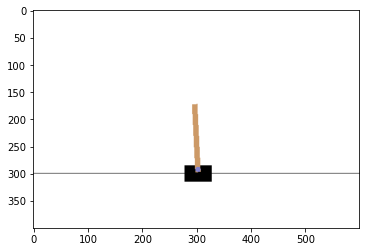

In [2]:
env = gym.make('CartPole-v0')
env.reset()
print("Cart Pole Environment")
plt.imshow(env.render('rgb_array'))

In [3]:
# Q Learning Learning agent class
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + self.gamma * \
                       self.get_Q(next_state, best_next_action) - \
                       self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

#### Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size  # max number of items in buffer
        self.buffer = []   # array to holde buffer

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        self.buffer = self.buffer[-self.size:] + [item]

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = \
            list(zip(*samples))
        return states, actions, rewards, next_states, done_flags

In [5]:
# training algorithm with reply buffer
def train_agent(env, agent, episode_cnt=10000, tmax=10000,
                anneal_eps=True, replay_buffer=None, batch_size=16):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            if replay_buffer:
                replay_buffer.add(state, action, reward, next_state, done)
                states, actions, rewards, next_states, done_flags = \
                        replay_buffer(batch_size)
                for i in range(batch_size):
                    agent.update(states[i], actions[i], rewards[i],
                                 next_states[i], done_flags[i])
            else:
                agent.update(state, action, reward, next_state, done)

            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [6]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(0, 200)
    plt.show()

#### Making state discrete

Cart Pole has 4 states:

- x-position: between values -4.8 to 4.8
- x-velocity: -$\infty$ to $\infty$ but we know it will not go significantly high or low
- pole-angle: -24 to 24 degrees
- pole angular velocity: -$\infty$ to $\infty$ but again it may not go too high from origin.

We can experiment and discretize each of the 4 values with some granularity. The values I am suggesting below are based on the various trial and error that was carried out to converge on some reasonable range. However, a more thorough approach would be to plot the 4 state values across multiple samples and see the distribution to arrive at a better approach to making values discrete.




In [7]:
# We will use ObservationWrapper class from gym to wrap our environment.
# We need to implement observation() method which will receive the
# original state values from underlying environment
# In observation() we will discretize the state values
# which then will be passed to outside world by env
# the agent will use these discrete state values
# to learn an effective policy using q-learning
from gym.core import ObservationWrapper


class Discretizer(ObservationWrapper):
    def observation(self, state):
        discrete_x_pos = round(state[0], 1)
        discrete_x_vel = round(state[1], 1)
        discrete_pole_angle = round(state[2], 1)
        discrete_pole_ang_vel = round(state[3], 1)

        return (discrete_x_pos, discrete_x_vel,
                discrete_pole_angle, discrete_pole_ang_vel)

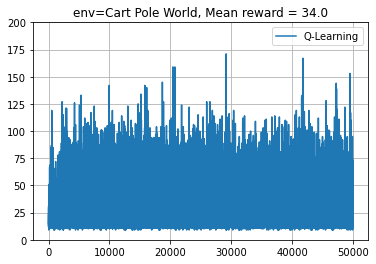

In [8]:
# create Cart Pole environment
# using .env will remove the time limit termination of 200 steps
env = gym.make('CartPole-v0').env  

# wrap our env with Discretizer
env = Discretizer(env)

# create a Q Learning agent
agent = QLearningAgent(alpha=0.5, epsilon=0.20, gamma=0.99, 
                       get_possible_actions=lambda s : range(env.action_space.n))

# train agent using replay buffer and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 50000)

# plot rewards
plot_rewards("Cart Pole World",rewards, 'Q-Learning')

In [9]:
env.close()

### Conclusion

Q agent with discretization of states is able to get rewards around 50 compared the maximum reward of 200. In Subsequent chapters, We will study other more powerful methods to obtain higher rewards.